# Layer and Attribute Assortativy 
# of Multilayer Graphs

## Moses A. Boudourides

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import colors
import colorsys
from collections import Counter
import random
import math
import itertools
from itertools import count
import operator
import numpy as np
# import scipy as sp
import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.drawing.nx_agraph import to_agraph 
# from pylab import hist
from IPython.display import Image
from IPython.core.display import HTML 
# from netwulf import visualize
import community
import leidenalg
import igraph as ig

## 1. Graph Partitions & Graph Decompositions

In [2]:
def is_part(G,P):
    t=[]
    for i in P:
        if len(i)!=0:
            if sorted([qq for q in P for qq in q])==sorted(G.nodes()):
                t.append(0)
            else:
                t.append(1)
    for k in list(itertools.combinations(P, 2)):
        if len(set(k[0]).intersection(set(k[1])))==0:
            t.append(0)
        else:
            t.append(1)
    if list(set(t))==[0]:
        return True 
    else:
        return False 
    
def is_decomp(G,P):
    t=[]
    for i in P:
        if len(i)!=0:
            if sorted([qq for q in P for qq in q])==sorted(G.nodes()):
                t.append(0)
    if list(set(t))==[0]:
        return True 
    else:
        return False 

In [3]:
def chunk(xs, n):
    ys = list(xs)
    random.shuffle(ys)
    size = len(ys) // n
    leftovers= ys[size*n:]
    for c in xrange(n):
        if leftovers:
           extra= [ leftovers.pop() ] 
        else:
           extra= []
        Y=ys[c*size:(c+1)*size] + extra
        yield sorted(Y)

def rpart(X,k):
    P=list(chunk(X,k))
    return P
    

def rdecomp(X,k,r1,r2,r3):
    while True:
        P=[]
        for i in range(k):
            n=random.choice(range(r1,r2+1)) #1,len(X)))
            P.append(sorted(random.sample(X,n)))
        if set([qq for q in P for qq in q])==set(X):
#             for j in list(itertools.combinations(range(k), 2)):
#                 if len(set(P[j[0]]).intersection(set(P[j[1]])))>r3-1:
            break
    return P

In [4]:
# nl=2 # number of layers
# n=50 # (total) number of nodes
# r1=35 # minimum number of nodes in layers
# r2=40 # maximum number of nodes in layers
# r3=25 # minimum number of common nodes among layers
# X=range(n)

nl=5 # number of layers
n=50 # (total) number of nodes
r1=20 # minimum number of nodes in layers
r2=25 # maximum number of nodes in layers
r3=10 # minimum number of common nodes among layers
X=range(n)

P=rdecomp(X,nl,r1,r2,r3)

print len(P), [len(p) for p in P]
print P
for k in list(itertools.combinations(range(nl), 2)):
    print "P%i-P%i %i" %(k[0],k[1],len(set(P[k[0]]).intersection(set(P[k[1]]))))       

5 [22, 22, 21, 25, 23]
[[2, 4, 7, 9, 11, 13, 15, 16, 17, 21, 22, 24, 26, 27, 29, 30, 32, 35, 40, 44, 46, 49], [2, 3, 6, 7, 8, 10, 11, 17, 19, 20, 22, 29, 30, 31, 36, 38, 39, 41, 43, 45, 46, 49], [0, 1, 5, 8, 10, 12, 14, 16, 18, 19, 22, 23, 24, 25, 30, 33, 34, 37, 42, 44, 47], [2, 5, 6, 8, 10, 11, 12, 15, 16, 18, 19, 20, 22, 23, 25, 27, 30, 32, 36, 41, 43, 44, 46, 47, 49], [6, 9, 10, 11, 12, 13, 15, 17, 18, 20, 25, 26, 28, 29, 30, 32, 35, 36, 38, 42, 44, 46, 48]]
P0-P1 9
P0-P2 5
P0-P3 11
P0-P4 12
P1-P2 5
P1-P3 14
P1-P4 10
P2-P3 13
P2-P4 7
P3-P4 13


## 2. Multilayer Graph Construction

In [5]:
GGd={}
for i,j in list(enumerate(P)):
#     print len(j),j
#     print
    while True:
        Gp=nx.erdos_renyi_graph(len(j),0.15)
#         Gp=nx.complete_graph(j)
        if nx.is_connected(Gp):
            break
#         Gp=nx.Graph()
#         Gp.add_nodes_from(j)

#         if len(Gp.edges())<1:
#         if nx.number_of_isolates(Gp)>3:
    GGd[i]=Gp

GG=[]

for k,v in GGd.items():
    mapping={}
    for i,j in list(enumerate(P)):
        if k==i:
            for ii,jj in list(enumerate(j)):
                for nn,node in list(enumerate(v.nodes())):
                    if nn==ii:
                        mapping[node]="L"+str(k)+"_"+str(jj)
#             mapping={jj:"L"+str(k)+"_"+str(jj) for jj in v.nodes()}
    Hp = nx.relabel_nodes(v, mapping)
    GG.append(Hp)
    
# for g in GG:
#     print len(g.nodes()),len(g.edges()),g.nodes()
#     print

In [6]:
leds=[]
for graph in GG:
#     print len(graph),len(graph.edges())
    for e in graph.edges(): 
        leds.append(e)
lG=nx.Graph()
lG.add_edges_from(leds)
print "lG",len(lG.nodes()),len(lG.edges()) #,lG.nodes()

npartition={}
for node in lG.nodes():
    s=node.index("_")
    sx=node[:s]
    npartition[node]=int(sx.replace("L",""))

lmembership={}
for node in lG.nodes():
    s=node.index("_")
    sx=node[:s] #.replace("L","")
    sxi=int(node[:s].replace("L",""))
#     print node, type(node)
#     t=[]
    for i,p in list(enumerate(P)):
#         print node,sx,p
        if sxi in p:
            lmembership[node]=sx #"L"+str(i)
#             t.append("L_"+str(i))
#     lmembership[node]=t
# print lmembership
nx.set_node_attributes(lG, lmembership, 'layer')
# for node in lG.nodes(data=True):
#     print node
# print lG.nodes(data=True)

# groups = set(nx.get_node_attributes(lG,'layer').values())
# mapping = dict(zip(sorted(groups),count()))
# nodes = lG.nodes()
# colors = [mapping[lG.node[n]['layer']] for n in nodes]
# cmap=plt.cm.tab10 #viridis #plt.cm.coolwarm #plt.cm.Blues #
# pos = graphviz_layout(lG);  #nx.spring_layout(G, iterations=1000) #

# plt.figure(figsize=(10,7));
# node_border_color='k'
# # nodes = nx.draw_networkx_nodes(lG, pos, node_color=ncolors) #[v for k,v in npartition.items() if k in lG.nodes()], cmap=cmap, vmin=min([v for k,v in npartition.items() if k in lG.nodes()]), vmax=max([v for k,v in npartition.items() if k in lG.nodes()]))
# # [v for k,v in npartition.items()] if k in lG.nodes()
# nodes= nx.draw_networkx_nodes(lG, pos, nodelist=nodes, node_color=colors, with_labels=False, node_size=150, cmap=cmap) #plt.cm.jet)
# nodes.set_edgecolor(node_border_color)
# nx.draw_networkx_edges(lG, pos,edge_color='b',alpha=0.8)
# # nx.draw_networkx_labels(lG, pos);
# plt.axis('off');
# # sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# # sm.set_array([])
# # cbar = plt.colorbar(sm,label="Layers") 
# yoffset = {}
# y_off =-20 #0.07  # offset on the y axis
# for k, v in pos.items():
#     yoffset[k] = (v[0], v[1]+y_off)
# # nx.draw_networkx_labels(lG, yoffset);
# plt.margins(x=0.1, y=0.1)

lG 113 193


teds 333 99
leds 193 193
eds 292 292
lG 113 193
G 113 292


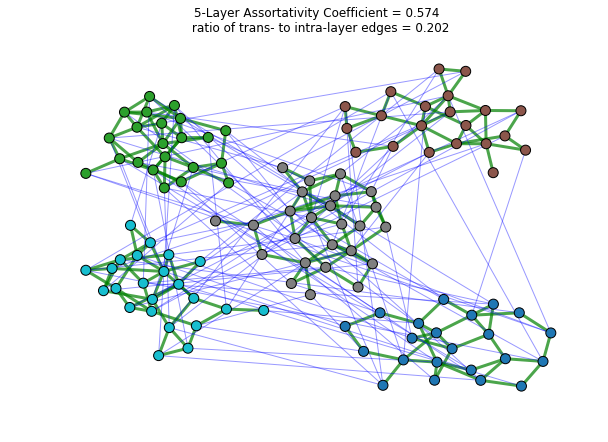

In [7]:
xmembership={}
for x in X:
    t=[]
    for i,j in list(enumerate(P)):
        if x in j:
            t.append("L"+str(i))
    xmembership[x]=t

teds=[]
# print lmembership
for node in lG.nodes():
    s=node.index("_")
    sx=int(node[s+1:])
#     print sx,type(sx) #,xmembership[sx]
    for k in list(itertools.combinations(xmembership[sx], 2)):
        t=[]
        for i,graph in list(enumerate(GG)):
            if k[0]+"_"+str(sx) in graph.nodes():
                t.append(i)
            if k[1]+"_"+str(sx) in graph.nodes():
                t.append(i)
        if len(t)>1:
#             print k,t
#         if k[0]+"_"+str(sx) in GGd[sx] and k[1]+"_"+str(sx) in GGd[sx]:
            te=(k[0]+"_"+str(sx),k[1]+"_"+str(sx))
#             if te not in teds:
            teds.append(te)
eds=leds+list(set(teds))
print "teds",len(teds),len(set(teds))
print "leds",len(leds),len(set(leds))
# print len(teds),len(eds)
print "eds",len(eds),len(set(eds))
G=nx.Graph()
G.add_edges_from(eds)
print "lG",len(lG.nodes()),len(lG.edges())#,sorted(list(lG.nodes()))[:3]
print "G",len(G.nodes()),len(G.edges())#,sorted(list(G.nodes()))[:3]

npartition={}
for node in G.nodes():
    s=node.index("_")
    sx=node[:s]
    npartition[node]=int(sx.replace("L",""))

lmembership={}
for node in G.nodes():
    s=node.index("_")
    sx=node[:s] #.replace("L","")
    sxi=int(node[:s].replace("L",""))
#     print node, type(node)
#     t=[]
    for i,p in list(enumerate(P)):
#         print node,sx,p
        if sxi in p:
            lmembership[node]=sx #"L"+str(i)
#             t.append("L_"+str(i))
#     lmembership[node]=t
# print lmembership
nx.set_node_attributes(G, lmembership, 'layer')
# for node in lG.nodes(data=True):
#     print node
# print lG.nodes(data=True)

groups = set(nx.get_node_attributes(G,'layer').values())
mapping = dict(zip(sorted(groups),count()))
nodes = G.nodes()
colors = [mapping[G.node[n]['layer']] for n in nodes]
cmap=plt.cm.tab10 #viridis #plt.cm.coolwarm #plt.cm.Blues #

pos = graphviz_layout(lG);  #nx.spring_layout(G, iterations=1000) #

plt.figure(figsize=(10,7));
node_border_color='k'
# nodes = nx.draw_networkx_nodes(lG, pos, node_color=ncolors) #[v for k,v in npartition.items() if k in lG.nodes()], cmap=cmap, vmin=min([v for k,v in npartition.items() if k in lG.nodes()]), vmax=max([v for k,v in npartition.items() if k in lG.nodes()]))
# [v for k,v in npartition.items()] if k in lG.nodes()
nodes= nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, with_labels=False, node_size=100, cmap=cmap) #plt.cm.jet)
nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(G, pos,edgelist=[e for e in G.edges() if e in lG.edges()],edge_color='g',width=3,alpha=0.7)
# nx.draw_networkx_edges(G, pos,edgelist=[e for e in G.edges() if e in teds],edge_color='b',alpha=0.4)
nx.draw_networkx_edges(G, pos,edgelist=[e for e in G.edges() if e not in lG.edges()],edge_color='b',alpha=0.4)
# nx.draw_networkx_labels(lG, pos);
plt.axis('off');
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# sm.set_array([])
# cbar = plt.colorbar(sm,label="Layers") 
intra=len([e for e in G.edges() if e in lG.edges()])
trans=len([e for e in G.edges() if e in teds])
dt=trans/float(intra)
sst="%i-Layer Assortativity Coefficient = %.3f \n ratio of trans- to intra-layer edges = %.3f" %(nl,nx.attribute_assortativity_coefficient(G,'layer'),dt)
plt.title(sst);
yoffset = {}
y_off =-20 #0.07  # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
# nx.draw_networkx_labels(lG, yoffset,font_size=8);
plt.margins(x=0.1, y=0.1)

## 3. Nodal Attributes

### COLORS

In [8]:
import matplotlib as mpl

def plot_cmap(cmap, ncolor):
    """ 
    A convenient function to plot colors of a matplotlib cmap
 
    Args:
        ncolor (int): number of color to show
        cmap: a cmap object or a matplotlib color name
    """
 
    if isinstance(cmap, str):
        try:
            cm = plt.get_cmap(cmap)
        except ValueError:
            print("WARNINGS :", cmap, " is not a known colormap")
            cm = plt.cm.gray
    else:
        cm = cmap
 
    with mpl.rc_context(mpl.rcParamsDefault):
        fig = plt.figure(figsize=(6, 1), frameon=False)
        ax = fig.add_subplot(111)
        ax.pcolor(np.linspace(1, ncolor, ncolor).reshape(1, ncolor), cmap=cm)
        ax.set_title(cm.name)
        xt = ax.set_xticks([])
        yt = ax.set_yticks([])
    return fig

import matplotlib.pyplot as plt
 
def show_colors(colors):
    """
    Draw a square for each color contained in the colors list
    given in argument.
    """
    with plt.rc_context(plt.rcParamsDefault):
        fig = plt.figure(figsize=(6, 1), frameon=False)
        ax = fig.add_subplot(111)
        for x, color in enumerate(colors):
            ax.add_patch(
                mpl.patches.Rectangle(
                    (x, 0), 1, 1, facecolor=color
                )
            )
        ax.set_xlim((0, len(colors)))
        ax.set_ylim((0, 1))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("equal")
 
    return fig

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def _get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

In [9]:
# fig = plot_cmap("summer", 6)

In [10]:
# colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
# show_colors(colors)

In [11]:
# dcm=discrete_cmap(20, base_cmap="summer")
# fig = plot_cmap(dcm, 20)

In [12]:
# # https://matplotlib.org/examples/color/named_colors.html

# cmap = colors.ListedColormap(['m','b','y','g','r','c','gray','orange','pink','yellowgreen'])
# fig = plot_cmap(cmap, 10)

In [13]:
numa=3 #number of attributes in a layer (the same number for all layers)

lnodes=[]
for k in range(nl):
    lnodes.append([node for node in G.nodes() if "L"+str(k) in node])
# lnodes=[[node for node in G.nodes() if "L0" in node],[node for node in G.nodes() if "L1" in node]]
print len(G.nodes())
for k in range(nl):
    print len(lnodes[k])
PP=[]
for l in lnodes:
    P=rpart(l,numa)
    PP.append(P)
    print len(P), [len(p) for p in P]
    print P
    for k in list(itertools.combinations(range(2), 2)):
        print "P%i-P%i %i" %(k[0],k[1],len(set(P[k[0]]).intersection(set(P[k[1]]))))
PPf=[]
for layer in PP:
    for group in layer:
        PPf.append(group)
print len(PPf),PPf,is_part(G,PPf)

113
22
22
21
25
23
3 [8, 7, 7]
[['L0_11', 'L0_21', 'L0_22', 'L0_24', 'L0_29', 'L0_32', 'L0_7', 'L0_9'], ['L0_15', 'L0_16', 'L0_17', 'L0_2', 'L0_27', 'L0_35', 'L0_40'], ['L0_13', 'L0_26', 'L0_30', 'L0_4', 'L0_44', 'L0_46', 'L0_49']]
P0-P1 0
3 [8, 7, 7]
[['L1_10', 'L1_17', 'L1_19', 'L1_20', 'L1_29', 'L1_3', 'L1_38', 'L1_49'], ['L1_11', 'L1_30', 'L1_36', 'L1_43', 'L1_46', 'L1_6', 'L1_8'], ['L1_2', 'L1_22', 'L1_31', 'L1_39', 'L1_41', 'L1_45', 'L1_7']]
P0-P1 0
3 [7, 7, 7]
[['L2_1', 'L2_14', 'L2_16', 'L2_18', 'L2_30', 'L2_47', 'L2_5'], ['L2_22', 'L2_23', 'L2_24', 'L2_25', 'L2_34', 'L2_37', 'L2_42'], ['L2_0', 'L2_10', 'L2_12', 'L2_19', 'L2_33', 'L2_44', 'L2_8']]
P0-P1 0
3 [9, 8, 8]
[['L3_11', 'L3_12', 'L3_18', 'L3_2', 'L3_27', 'L3_30', 'L3_32', 'L3_46', 'L3_5'], ['L3_10', 'L3_16', 'L3_23', 'L3_41', 'L3_44', 'L3_49', 'L3_6', 'L3_8'], ['L3_15', 'L3_19', 'L3_20', 'L3_22', 'L3_25', 'L3_36', 'L3_43', 'L3_47']]
P0-P1 0
3 [8, 8, 7]
[['L4_11', 'L4_18', 'L4_20', 'L4_25', 'L4_32', 'L4_35', 'L4_36', 'L4

In [14]:
lcls=['m','b','y','g','r','c','gray','orange','pink','yellowgreen','indianred','wheat','limegreen','teal','indigo']
random.shuffle(lcls)
cls=mpl.colors.cnames.values()
clsl=random.sample(cls,numa*nl)

colorattr={}
if len(PPf)==4:
    for node in G.nodes():
        if node in PPf[0]:
            colorattr[node]='m'
        elif node in PPf[1]:
            colorattr[node]='c'
        elif node in PPf[2]:
            colorattr[node]='orange'
        else:
            colorattr[node]='pink'
elif len(PPf)>4 and len(PPf)<16:
    for node in G.nodes():
        for j in range(numa*nl):
            if node in PPf[j]:
                colorattr[node]=lcls[j] #random.sample(lcls,len(PPf))[j]
else:
    for node in G.nodes():
        for j in range(numa*nl):
            if node in PPf[j]:
                colorattr[node]=clsl[j]
            
nx.set_node_attributes(G, colorattr, 'attribute')

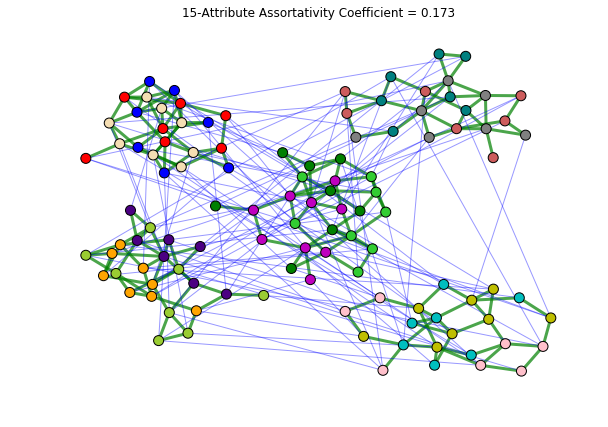

In [15]:
import matplotlib as mpl

groups = set(nx.get_node_attributes(G,'attribute').values())
mapping = dict(zip(sorted(groups),sorted(groups)))  #count()))
nodes = G.nodes()
mycolors = [mapping[G.node[n]['attribute']] for n in nodes]
# cmap=plt.cm.tab10 #viridis #plt.cm.coolwarm #plt.cm.Blues #
cmap = mpl.colors.ListedColormap(list(groups)) #['m','c','orange','pink'])
    
pos = graphviz_layout(lG);  #nx.spring_layout(G, iterations=1000) #

plt.figure(figsize=(10,7));
node_border_color='k'
# nodes = nx.draw_networkx_nodes(lG, pos, node_color=ncolors) #[v for k,v in npartition.items() if k in lG.nodes()], cmap=cmap, vmin=min([v for k,v in npartition.items() if k in lG.nodes()]), vmax=max([v for k,v in npartition.items() if k in lG.nodes()]))
# [v for k,v in npartition.items()] if k in lG.nodes()
nodes= nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=mycolors, with_labels=False, node_size=100, cmap=cmap) #plt.cm.jet)
nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(G, pos,edgelist=[e for e in G.edges() if e in lG.edges()],edge_color='g',width=3,alpha=0.7)
# nx.draw_networkx_edges(G, pos,edgelist=[e for e in G.edges() if e in teds],edge_color='b',alpha=0.4)
nx.draw_networkx_edges(G, pos,edgelist=[e for e in G.edges() if e not in lG.edges()],edge_color='b',alpha=0.4)
# nx.draw_networkx_labels(lG, pos);
plt.axis('off');
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# sm.set_array([])
# cbar = plt.colorbar(sm,label="Layers") 
# intra=len([e for e in G.edges() if e in lG.edges()])
# trans=len([e for e in G.edges() if e in teds])
# dt=trans/float(intra)
sst="%i-Attribute Assortativity Coefficient = %.3f" %(numa*nl,nx.attribute_assortativity_coefficient(G,'attribute'))
plt.title(sst);
yoffset = {}
y_off =-20 #0.07  # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
# nx.draw_networkx_labels(lG, yoffset,font_size=8);
plt.margins(x=0.1, y=0.1)

## 4. Intra-Layer Attribute Assortativity Coefficients

In [16]:
for k in range(nl):
    lsG=G.subgraph(lnodes[k])
    ac=nx.attribute_assortativity_coefficient(lsG,'attribute')
    print "Layer %i has attribute assortativity coefficient = %.3f" %(k,ac)

Layer 0 has attribute assortativity coefficient = 0.038
Layer 1 has attribute assortativity coefficient = -0.130
Layer 2 has attribute assortativity coefficient = -0.080
Layer 3 has attribute assortativity coefficient = 0.074
Layer 4 has attribute assortativity coefficient = 0.137


## 5. Community Partitioning

In [17]:
partition = community.best_partition(G)

kk=len(set(partition.values()))
modularity=community.modularity(partition, G, weight='weight')
print 'The graph has', kk, 'Louvain communities and modularity coefficient equal to', modularity
print partition

cml=[]
for j in range(kk):
    cj=[]
    for k,v in partition.items():
        if v==j:
            cj.append(k)
    cml.append(cj)
cmd={}
for j in range(kk):
    cmd[tuple(cml[j])]=len(cml[j])
cmd
ocmd=sorted(cmd.iteritems(), key=operator.itemgetter(1), reverse=True)
eocmd=enumerate(ocmd)
commsd={}
louvain_comm_membership={}
for i in eocmd:
    print 'Community', i[0], 'with', i[1][1], 'nodes:', list(i[1][0])
    commsd[i[0]]=i[1][1] 
    ts=list(i[1][0])
    louvain_comm_membership[i[0]]=ts 

The graph has 10 Louvain communities and modularity coefficient equal to 0.467500938262
{'L4_28': 0, 'L1_22': 1, 'L3_30': 0, 'L1_20': 0, 'L3_36': 7, 'L4_29': 2, 'L4_20': 0, 'L1_29': 2, 'L4_25': 3, 'L4_26': 0, 'L3_43': 6, 'L0_9': 9, 'L2_30': 0, 'L2_33': 7, 'L2_34': 5, 'L2_37': 7, 'L0_2': 9, 'L0_24': 4, 'L0_26': 0, 'L0_27': 5, 'L0_21': 4, 'L0_22': 1, 'L0_29': 2, 'L1_41': 8, 'L2_42': 5, 'L4_48': 3, 'L3_44': 7, 'L1_43': 6, 'L4_11': 8, 'L4_10': 6, 'L4_13': 6, 'L4_12': 0, 'L1_38': 6, 'L1_39': 2, 'L4_17': 6, 'L4_18': 3, 'L1_36': 0, 'L1_30': 0, 'L1_31': 6, 'L3_49': 2, 'L3_16': 5, 'L2_47': 7, 'L2_22': 1, 'L2_23': 5, 'L3_41': 6, 'L1_46': 2, 'L3_47': 7, 'L3_46': 2, 'L2_24': 5, 'L2_25': 5, 'L2_1': 5, 'L2_0': 5, 'L2_5': 5, 'L3_20': 0, 'L2_8': 8, 'L4_9': 9, 'L0_15': 4, 'L0_17': 6, 'L0_16': 5, 'L0_11': 8, 'L0_13': 6, 'L4_6': 9, 'L3_18': 5, 'L3_19': 5, 'L2_14': 5, 'L2_12': 0, 'L2_10': 6, 'L3_10': 6, 'L3_11': 8, 'L3_12': 0, 'L1_3': 2, 'L1_45': 0, 'L3_15': 4, 'L2_19': 5, 'L2_18': 5, 'L1_6': 9, 'L1_7': 8

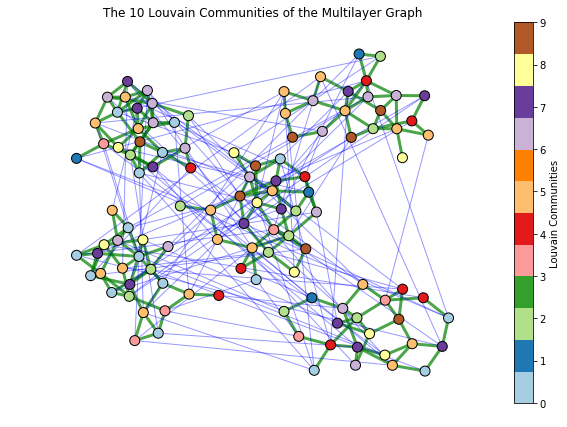

In [18]:
node_color=partition.values()
# [partition[n] for n in G.nodes()]
# range(len(G.nodes())) #[d[n] for n in G.nodes()]
vmin = min(node_color) #df['color'].min()
vmax = max(node_color) #df['color'].max()
cmap=plt.cm.Paired #tab10 #viridis #plt.cm.coolwarm #plt.cm.Blues #

plt.figure(figsize=(10,7));
# pos = graphviz_layout(G) #nx.spring_layout(G, iterations=1000) #
node_border_color='k'
# nodes = nx.draw_networkx_nodes(G, pos, node_color=node_color, cmap=cmap, vmin=vmin, vmax=vmax,node_size=100)
# nodes.set_edgecolor(node_border_color)
# nx.draw_networkx_edges(G, pos,edge_color='b',alpha=0.8)
nodes= nx.draw_networkx_nodes(G, pos, with_labels=False, node_size=100, node_color=node_color, cmap=cmap, vmin=vmin, vmax=vmax); #plt.cm.jet)
# nodelist=nodes, 
nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(G, pos,edgelist=[e for e in G.edges() if e in lG.edges()],edge_color='g',width=3,alpha=0.7)
# nx.draw_networkx_edges(G, pos,edgelist=[e for e in G.edges() if e in teds],edge_color='b',alpha=0.4)
nx.draw_networkx_edges(G, pos,edgelist=[e for e in G.edges() if e not in lG.edges()],edge_color='b',alpha=0.4)
# nx.draw_networkx_labels(lG, pos);
plt.axis('off');
yoffset = {}
y_off = -0.05  # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
# nx.draw_networkx_labels(G, yoffset);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,label="Louvain Communities") #, orientation='horizontal')
plt.margins(x=0.1, y=0.1)
plt.title("The %i Louvain Communities of the Multilayer Graph" %kk);

In [19]:
mapping = dict(zip(sorted(G.nodes()),count()))
Gig=nx.relabel_nodes(G, mapping)
invmapping={v:k for k,v in mapping.items()}

g = ig.Graph(directed=False)
g.add_vertices(Gig.nodes())
g.add_edges(Gig.edges())

partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition);
# partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition, weights=’weight’);

kk=len(list(partition))
partd={}
for i,j in list(enumerate(cml)):
    for jj in j:
        partd[jj]=i
ipartd={} #{invmapping[k]:v for k,v in partd.items()}
for k,v in partd.items():
    vv=invmapping[v]
    ipartd[k]=vv

modularity=community.modularity(partd, G, weight='weight')
print 'The graph has', kk, 'Leiden communities and modularity coefficient equal to', modularity
print ipartd

cml=list(partition)
cmd={}
for j in range(kk):
    cmd[tuple(cml[j])]=len(cml[j])
cmd
ocmd=sorted(cmd.iteritems(), key=operator.itemgetter(1), reverse=True)
eocmd=enumerate(ocmd)
commsd={}
leiden_comm_membership={}
for i in eocmd:
    iii=[invmapping[ii] for ii in list(i[1][0])]
    print 'Community', i[0], 'with', i[1][1], 'nodes:', iii #list(i[1][0])
    commsd[i[0]]=i[1][1] 
    ts=list(iii)
    leiden_comm_membership[i[0]]=ts 

The graph has 10 Leiden communities and modularity coefficient equal to 0.467500938262
{'L4_28': 'L0_11', 'L1_22': 'L0_13', 'L1_20': 'L0_11', 'L4_29': 'L0_15', 'L4_20': 'L0_11', 'L1_29': 'L0_15', 'L4_25': 'L0_16', 'L4_26': 'L0_11', 'L1_19': 'L0_2', 'L0_24': 'L0_17', 'L0_26': 'L0_11', 'L0_27': 'L0_2', 'L0_21': 'L0_17', 'L0_22': 'L0_13', 'L0_29': 'L0_15', 'L2_12': 'L0_11', 'L1_38': 'L0_21', 'L1_39': 'L0_15', 'L1_36': 'L0_11', 'L1_30': 'L0_11', 'L1_31': 'L0_21', 'L3_49': 'L0_15', 'L3_43': 'L0_21', 'L3_41': 'L0_21', 'L3_47': 'L0_22', 'L3_46': 'L0_15', 'L3_44': 'L0_22', 'L1_49': 'L0_15', 'L1_41': 'L0_24', 'L1_43': 'L0_21', 'L1_45': 'L0_11', 'L1_46': 'L0_15', 'L1_6': 'L0_26', 'L1_7': 'L0_24', 'L1_2': 'L0_26', 'L1_3': 'L0_15', 'L4_46': 'L0_15', 'L4_44': 'L0_22', 'L1_8': 'L0_24', 'L0_7': 'L0_17', 'L0_40': 'L0_17', 'L0_46': 'L0_15', 'L0_44': 'L0_22', 'L0_49': 'L0_15', 'L2_30': 'L0_11', 'L3_20': 'L0_11', 'L3_23': 'L0_2', 'L3_22': 'L0_13', 'L3_25': 'L0_22', 'L3_27': 'L0_2', 'L2_44': 'L0_22', 'L2_

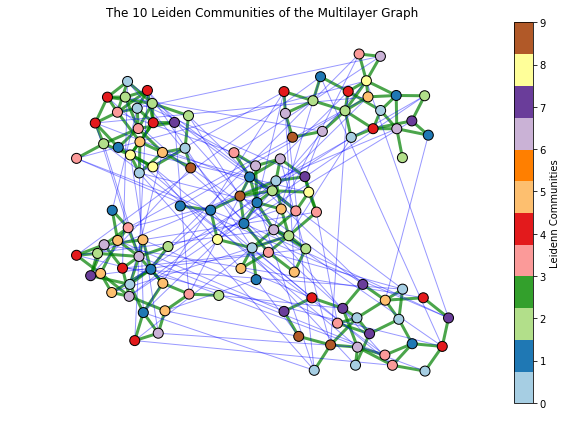

In [20]:
partd={}
for i,j in list(enumerate(cml)):
    for jj in j:
        partd[jj]=i

node_color=partd.values()
# [partition[n] for n in G.nodes()]
# range(len(G.nodes())) #[d[n] for n in G.nodes()]
vmin = min(node_color) #df['color'].min()
vmax = max(node_color) #df['color'].max()
cmap=plt.cm.Paired #tab10 #viridis #plt.cm.coolwarm #plt.cm.Blues #

plt.figure(figsize=(10,7));
# pos = graphviz_layout(G) #nx.spring_layout(G, iterations=1000) #
node_border_color='k'
# nodes = nx.draw_networkx_nodes(G, pos, node_color=node_color, cmap=cmap, vmin=vmin, vmax=vmax,node_size=100)
# nodes.set_edgecolor(node_border_color)
# nx.draw_networkx_edges(G, pos,edge_color='b',alpha=0.8)
nodes= nx.draw_networkx_nodes(G, pos, with_labels=False, node_size=100, node_color=node_color, cmap=cmap, vmin=vmin, vmax=vmax); #plt.cm.jet)
# nodelist=nodes, 
nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(G, pos,edgelist=[e for e in G.edges() if e in lG.edges()],edge_color='g',width=3,alpha=0.7)
# nx.draw_networkx_edges(G, pos,edgelist=[e for e in G.edges() if e in teds],edge_color='b',alpha=0.4)
nx.draw_networkx_edges(G, pos,edgelist=[e for e in G.edges() if e not in lG.edges()],edge_color='b',alpha=0.4)
# nx.draw_networkx_labels(lG, pos);
plt.axis('off');
yoffset = {}
y_off = -0.05  # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
# nx.draw_networkx_labels(G, yoffset);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,label="Leidenn Communities") #, orientation='horizontal')
plt.margins(x=0.1, y=0.1)
plt.title("The %i Leiden Communities of the Multilayer Graph" %kk);

In [21]:
def ccomp(A,B):
    eds=[]
    A1=set(A.keys())
    B1=set(B.keys())
    for i in A1:
        x=set(A[i])
        for j in B1:
            y=set(B[j])
            sd=sorted(list(x.symmetric_difference(y)))
            ss=sorted(list(set(list(x)+list(y))))
            if A[i]==B[j]:
                eds.append(("louvain_comm_"+str(i),"leiden_comm_"+str(j),1.))
            else:
                if len(sd)/float(len(ss))==1:
                    eds.append(("louvain_comm_"+str(i),"leiden_comm_"+str(j),0.))
                else:
                    eds.append(("louvain_comm_"+str(i),"leiden_comm_"+str(j),len(sd)/float(len(ss))))
    H = nx.Graph()
    H.add_weighted_edges_from(eds)
    H.remove_edges_from([e for e in H.edges(data=True) if e[2]['weight']==0.])       
    return H

### Comparison/Similarities of Louvain-Leiden Communities of the Multilayer Graph

In [22]:
def PointsInCircum(r,n):
    return [(math.cos(2*math.pi/n*x)*r,math.sin(2*math.pi/n*x)*r) for x in xrange(0,n+1)]

def PointsInCircum_n(r,n):
#     theta=(math.pi/2.)*(2*x/n +1)
    return [(math.cos(math.pi/n*x+math.pi/2)*r,math.sin(math.pi/n*x+math.pi/2)*r) for x in xrange(0,n+1)]
#     return [(math.cos((math.pi/2.)*(2*x/n +1))*r,math.sin((math.pi/2.)*(2*x/n +1))*r) for x in xrange(0,n+1)]

def PointsInCircum_p(r,n):
    return [(math.cos(math.pi/n*x+3*math.pi/2)*r,math.sin(math.pi/n*x+3*math.pi/2)*r) for x in xrange(0,n+1)]
#     theta=(math.pi/2.)*(2*x/n +3)
#     return [(math.cos(theta)*r,math.sin(theta)*r) for x in xrange(0,n+1)]

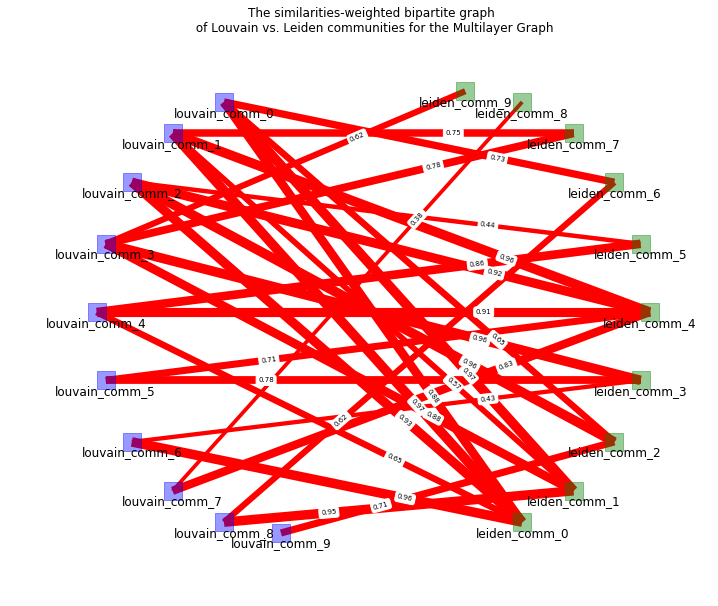

In [23]:
H=ccomp(louvain_comm_membership,leiden_comm_membership)

posbp={}
louvain=sorted([n for n in H.nodes() if "louvain" in n])
leiden=sorted([n for n in H.nodes() if "leiden" in n])
ci=PointsInCircum_n(1,n=len(louvain))
cin=[(p-0.5,q) for (p,q) in ci if p<0]
ci=PointsInCircum_p(1,n=len(leiden))
cip=[(p+0.5,q) for (p,q) in ci if p>0]
for node in louvain:
    ind=louvain.index(node)
    posbp[node]=cin[ind]   
for node in leiden:
    ind=leiden.index(node)
    posbp[node]=cip[ind]
    
# posbp={}
# louvain=sorted([n for n in H.nodes() if "louvain" in n])
# leiden=sorted([n for n in H.nodes() if "leiden" in n])
# M=max([len(louvain),len(leiden)])
# for n in H.nodes():
#     if len(louvain)==M:
#         for i,j in list(enumerate(louvain)):
#             posbp[j]=(0,i)
#         for i,j in list(enumerate(leiden)):
#             posbp[j]=(1,i*M/len(leiden)+(M-len(leiden))/4.)
#     else:
#         for i,j in list(enumerate(louvain)):
#             posbp[j]=(0,i/len(louvain)+(M-len(louvain))/4.)
#         for i,j in list(enumerate(leiden)):
#             posbp[j]=(1,i)

            
elabels={}
elabels = nx.get_edge_attributes(H,'weight')
elabelsc={}
for k,v in elabels.items():
    elabelsc[k]='%.02f' %v 
elabels=elabelsc
edge_width=[e[2]['weight'] for e in H.edges(data=True)]
edge_width=[10*w for w in edge_width]
plt.figure(figsize=(12,10));
nodes1 = nx.draw_networkx_nodes(H, posbp, nodelist=louvain,node_color="b",node_shape='s',alpha=0.4)
nodes2 = nx.draw_networkx_nodes(H, posbp, nodelist=leiden,node_color="g",node_shape='s',alpha=0.4)
nx.draw_networkx_edges(H, posbp, edge_color="r",width=edge_width, alpha=1.)
# nx.draw_networkx_labels(H, posbp)
nx.draw_networkx_edge_labels(H,posbp,edge_labels=elabels,label_pos = 0.7,font_size=7);
plt.axis('off');
yoffset = {}
y_off = -0.05  # offset on the y axis
for k, v in posbp.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(H, yoffset);
plt.margins(x=0.1, y=0.1)
plt.title("The similarities-weighted bipartite graph \n of Louvain vs. Leiden communities for the Multilayer Graph");